In [1]:
import numpy as np
import cffi
import ctypes
import matplotlib.pyplot as plt
from numba import jit

In [2]:
@jit
def goertzel(x,k,N):
    w = 2*np.pi*k/N;
    cw = np.cos(w);
    c = 2*cw;
    sw = np.sin(w);
    z1=0;
    z2=0;
    for idx in range(N):
        z0 = x[idx] + c*z1 -z2;
        z2 = z1;
        z1 = z0;

    I = cw*z1 -z2;
    Q = sw*z1;

    P = z2*z2 + z1*z1 - c * z1*z2
    return I, Q, P, z1, z2

In [4]:
raw = np.fromfile('single_tone_v2.dat', dtype=np.int32)
x = raw>>14

%timeit goertzel(x, 100, 256)

The slowest run took 11.10 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 3.29 µs per loop


In [152]:
!gcc -shared -Wl,-install_name,goertzel.so -o goertzel.so -fPIC goertzel.c

In [153]:
ffi = cffi.FFI()
ffi.cdef("""
double goertzel(int32_t *x, int32_t k);
double goertzel2(int32_t *x, double c, int32_t N, double *delays);
void slide_goertzel(int32_t *x, double c,
        int32_t block_size, int32_t N, double *P, double *delays); 
""")


In [154]:
C = ffi.dlopen('./goertzel.so')

In [7]:
raw = np.fromfile('single_tone_v2.dat', dtype=np.int32)
x = raw>>14
x_p = ffi.cast('int32_t *', x.ctypes.data)
delays = np.zeros(2);
delays_p = ffi.cast('double *', delays.ctypes.data)

NameError: name 'ffi' is not defined

In [156]:
k = 100
N = 256
w = 2 * np.pi * k / N;
c = 2 * np.cos(w);

In [157]:
%timeit C.goertzel(x_p, 100)

2.14 µs ± 157 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [158]:
%timeit C.goertzel2(x_p, c, 256, delays_p)

2.38 µs ± 424 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [159]:
C.goertzel(x_p, 100), C.goertzel2(x_p, c, 256, delays_p)

(116351040.91134441, 7.654766123429247e+19)

In [9]:
delays

array([-14768.61396444,   6071.12433535])

In [10]:
goertzel(x, k, N)

(5345.1686408340465,
 -9369.10951544429,
 116351040.91134441,
 -14768.61396443704,
 6071.124335354678)

In [5]:
# Sliding Goertzel
@jit
def sg(x, k=25*4):
    Pxx = []
    N = 64*4
    # k = 26*4
    w = 2*np.pi*k/N;
    cw = np.cos(w);
    c = 2*cw;
    sw = np.sin(w);
    # Initialize... no sliding because there aren't enough samples
    z1=0;
    z2=0;
    for idx in range(N):
        z0 = x[idx] + c*z1 -z2;
        z2 = z1;
        z1 = z0;

    # I = cw*z1 -z2;
    # Q = sw*z1;

    P = z2*z2 + z1*z1 - c * z1*z2
    print('P',P)
    Pxx.append(P)
    # return I, Q, P

    while (idx < (len(x)-1)):
        idx += 1
        z0 = x[idx] - x[idx-N] + c*z1 -z2;
        z2 = z1;
        z1 = z0;

        P = z2*z2 + z1*z1 - c * z1*z2
        Pxx.append(P)

    return np.array(Pxx)

P 116351040.91134441


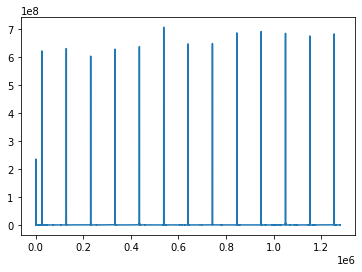

In [6]:
#%timeit sliding = sg(x)
sliding = sg(x, k=100)
plt.figure()
plt.plot(sliding)

In [276]:
sliding[:10]

array([1.16351041e+08, 8.82741850e+07, 4.63857837e+07, 1.39222984e+08,
       3.76046519e+07, 1.01906805e+08, 2.35188800e+08, 7.40378634e+03,
       3.60851928e+02, 7.62784665e+03])

In [14]:
goertzel(x, k, N)

(5345.1686408340465,
 -9369.10951544429,
 116351040.91134441,
 -14768.61396443704,
 6071.124335354678)

In [15]:
goertzel(x[1:], k, N)

(6486.996142777985,
 6796.548099984236,
 88274185.03181574,
 10713.461617022771,
 -14768.61396443704)

In [16]:
sliding[1]

88274185.03181574

In [17]:
block_size = 64
slidingPxx = np.zeros(block_size);
slidingPxx_p = ffi.cast('double *', slidingPxx.ctypes.data)

In [18]:
offset = 256
data = x[256:]
data_p = ffi.cast('int32_t *', data.ctypes.data)

In [22]:
%timeit C.slide_goertzel(data_p, c, block_size, offset, slidingPxx_p, delays_p)

1.19 µs ± 34.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [20]:
slidingPxx[0]

88274185.03181574

In [21]:
sliding[1:65] - slidingPxx

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
x = 25900
dx = np.arange(-128, 128)
while x < len(sliding):
    plt.plot(dx,sliding[x+dx])
    x += 102400
    print( (dx*sliding[x+dx]).sum() / sliding[x+dx].sum())

In [14]:
import scipy.signal

# IIR filter implementation of goertzel over first N

def goertzelIIR(x,k,N): 
    w = 2*np.pi*k/N
    W = np.exp(1j*w); 
    c = 2*np.cos(w); 
    
    # Filter coefficients
    b = [W, -1, 0];
    a = [1, -c, 1];
    
    y = scipy.signal.lfilter(b, a, x[:N]); 
    
    I = y[-1].real; 
    Q = y[-1].imag; 
    P = abs(y[-1])*abs(y[-1])
    return (I, Q, P)

In [15]:
x = raw>>14
%timeit goertzelIIR(x[1:257], 100, 256)

21.4 µs ± 2.27 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
goertzel(x[1:], 100, 256)

In [22]:
def thresholding_algo_v3(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y[:lag])
    avgFilter = np.mean(filteredY)
    stdFilter = np.std(filteredY)
    for i in range(lag, len(y)):
        if (y[i] - avgFilter) > threshold * stdFilter:
            signals[i] = 1
            filteredY[i%lag] = influence * y[i] + (1 - influence) * filteredY[(i-1)%lag]
        else:
            signals[i] = 0
            filteredY[i%lag] = y[i]
        avgFilter = np.mean(filteredY)
        stdFilter = np.std(filteredY)
    return signals

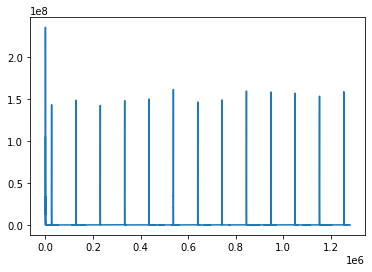

In [179]:
plt.plot(sliding)

25920.882996228112

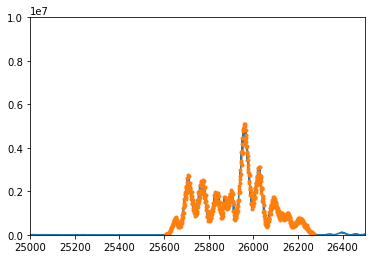

In [173]:
y = sliding[:50000]
signals = thresholding_algo_v3(y, 256, 10, 0.00001)
signals = signals.astype(bool)

t = np.arange(len(y))
plt.plot(t, y)
plt.plot(t[signals], y[signals],'.')
plt.axis([25000, 26500, 0, 1e7])
(t[signals]*y[signals]).sum() / y[signals].sum()
#gca = plt.gca()
#gca.set_yscale('log')

In [134]:
gca.set_yscale('log')

In [ ]:
1276348

-413933120


In [139]:
raw[1276347]

-109920256

In [140]:
hex(-413933120)

'-0x18ac1e40'

In [141]:
len(sliding)

1279745

In [142]:
1279745 + 255

1280000

In [144]:
sliding.tofile('sliding_goertzel.dat')

In [145]:
!ls -l *.dat

-rw-r--r--@ 1 nams  18670   5120000 Nov  2 14:05 single_tone.dat
-rw-r--r--@ 1 nams  18670   5120000 Nov  3 14:21 single_tone_v2.dat
-rw-r--r--  1 nams  18670  10237960 Nov  4 17:45 sliding_goertzel.dat


In [146]:
1279745 * 8


10237960

In [147]:
!zip sg.zip sliding_goertzel.dat


  adding: sliding_goertzel.dat (deflated 6%)


In [148]:
ls -l


total 60936
-rw-r--r--  1 nams  18670      1564 Nov  4 12:37 Untitled.ipynb
-rwxr-xr-x  1 nams  18670     49656 Nov  4 17:38 a.out*
-rw-r--r--  1 nams  18670       320 Nov  4 12:34 add.c
-rw-r--r--  1 nams  18670       408 Nov  4 12:33 add_new.c
-rwxr-xr-x  1 nams  18670     16520 Nov  4 12:34 adder.so*
-rw-r--r--  1 nams  18670      1424 Nov  4 09:21 goertzel.c
-rw-r--r--  1 nams  18670     38269 Nov  4 17:45 goertzel.ipynb
-rwxr-xr-x  1 nams  18670     49456 Nov  4 12:14 goertzel.so*
-rw-r--r--  1 nams  18670     21607 Nov  4 15:11 peak finding.ipynb
-rw-r--r--  1 nams  18670       798 Nov  4 17:38 read.c
-rw-r--r--  1 nams  18670   9594082 Nov  4 17:46 sg.zip
-rw-r--r--@ 1 nams  18670   5120000 Nov  2 14:05 single_tone.dat
-rw-r--r--  1 nams  18670    295292 Nov  4 12:41 single_tone.ipynb
-rw-r--r--@ 1 nams  18670   5120000 Nov  3 14:21 single_tone_v2.dat
-rw-r--r--  1 nams  18670  10237960 Nov  4 17:45 sliding_goertzel.dat
-rw-r--r--  1 nams  18670       278 Nov  4 12:33 test_adder

<IPython.core.display.Javascript object>


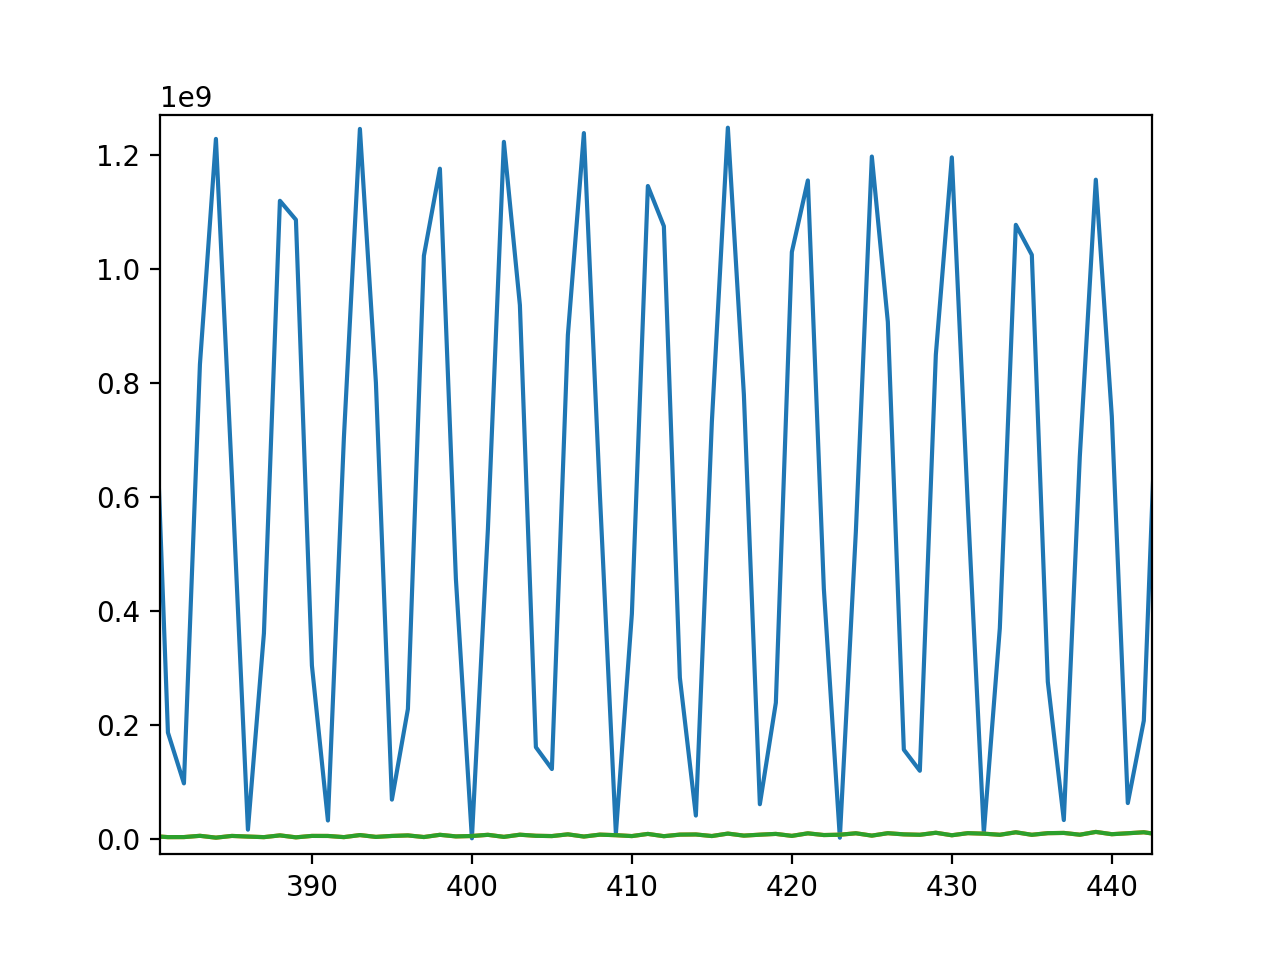

In [247]:
%matplotlib notebook
width = 4e-3
f = 25000+5
fs = 64000
t = np.arange(fs*width) / fs

cosine = np.cos(2*np.pi*f*t)
sine = np.cos(2*np.pi*f*t)

c_cross = np.correlate(x, cosine)
s_cross = np.correlate(x, sine)
crossP = c_cross*c_cross + s_cross*s_cross

plt.plot(crossP[25500:26200])

In [336]:
x = np.zeros((1<<16), dtype=np.int32)
write_addr = 0
read_addr = 0
def fill_x():
    x[write_addr:(write_addr+64)] = raw[read_addr:(read_addr+64)]
    write_addr += 64
    read_addr += 64
    write_addr 

In [259]:
Pxx = []
N = 64*4
# k = 26*4
w = 2*np.pi*k/N;
cw = np.cos(w);
c = 2*cw;
sw = np.sin(w);
# Initialize... no sliding because there aren't enough samples
z1=0;
z2=0;
for idx in range(N):
    z0 = x[idx] + c*z1 -z2;
    z2 = z1;
    z1 = z0;
    P = z2*z2 + z1*z1 - c * z1*z2
    Pxx.append(P)


In [334]:
raw

array([         0,          0,          0, ..., -109969408, -109936640,
       -109969408], dtype=int32)

In [277]:
sliding[0]

116351040.91134441

In [263]:
Pxx[:10]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 75342400.0,
 37340541.098740585,
 138453844.6532523,
 48841814.7149342,
 86300865.39388895]

In [367]:
filter_out = np.fromfile('/Users/nams/Documents/projects/gburg-ultrasonic/zmq/filter.out',dtype=np.double)

In [368]:
filter_out[:10]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.53424000e+07, 3.73405411e+07, 1.38453845e+08,
       4.88418147e+07, 8.63008654e+07])

In [369]:
len(filter_out), len(Pxx), len(sliding), Pxx[-1], sliding[0], len(filter_out[255:])

(1280000, 256, 1279745, 116351040.91134441, 116351040.91134441, 1279745)

In [370]:
Pxx[:64] - filter_out[:64]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [371]:
filter_out = filter_out[255:]
bad = np.where(sliding[:len(filter_out)] - filter_out)[0]
bad

array([], dtype=int64)

In [348]:
filter_out[0], sliding[0]

(116351040.91134441, 116351040.91134441)

In [349]:
bad

array([], dtype=int64)

In [356]:
sliding[:len(filter_out)] - filter_out

array([0., 0., 0., ..., 0., 0., 0.])

<IPython.core.display.Javascript object>


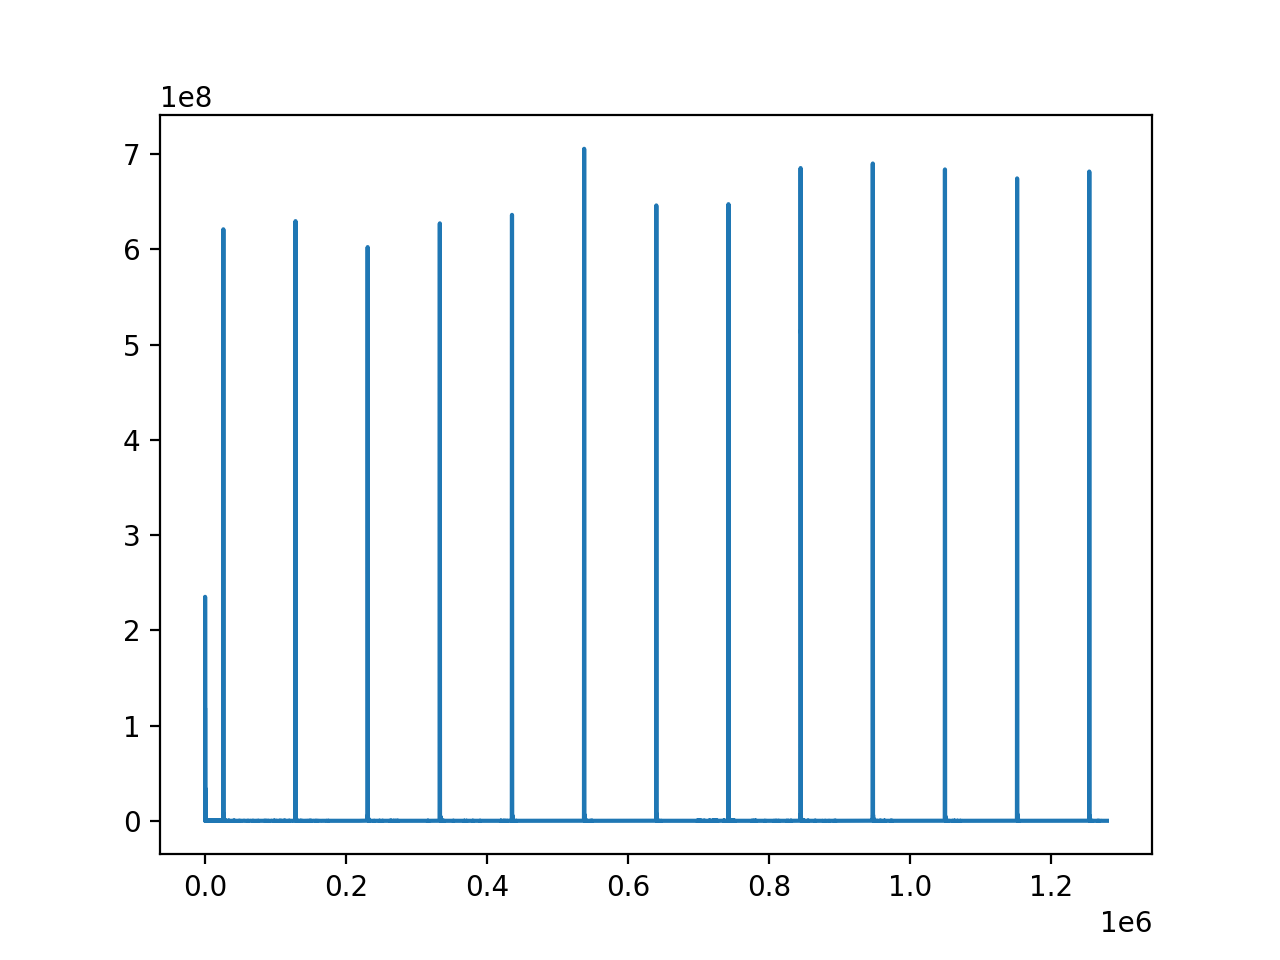

In [361]:
plt.figure();
plt.plot(filter_out)

In [416]:
filter_out2 = np.fromfile('/Users/nams/Documents/projects/gburg-ultrasonic/zmq/libzmq/filter.out.zmq', dtype=np.double)
filter_out = np.fromfile('/Users/nams/Documents/projects/gburg-ultrasonic/zmq/filter.out', dtype=np.double)

In [417]:
filter_out[:64], filter_out2[:64]



(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.53424000e+07, 3.73405411e+07, 1.38453845e+08,
        4.88418147e+07, 8.63008654e+07, 1.18170208e+08, 3.14311968e+07,
        1.33778418e+08, 6.23650576e+07, 7.03795511e+07, 1.29449927e+08,
        3.00718984e+07, 1.24644200e+08, 7.78396879e+07, 5.56667644e+07,
        1.36904142e+08, 3.35082176e+07, 1.12127012e+08, 9.40028583e+07,
        4.33898081e+07, 1.39856121e+08, 4.13735674e+07, 9.72092634e+07,
        1.09476159e+08, 3.46589791e+07, 1.38061008e+08, 5.30083063e+07,
        8.10989686e+07, 1.22807827e+08, 3.02504192e+07, 1.31638192e+08,
        6.74245583e+07, 6.52636466e+07, 1.32834792e+08, 3.05072714e+07,
        1.21147232e+08, 8.33657066e+07, 5.11089382e+07, 1.38727221e+08,
        3.55017644e+07, 1.07481619e+08, 9.94666285e+07, 3.98504419e+07,
        1.39972675e+08, 4.47206190e+07, 9.18558906e+07, 1.14289267e+08,
        3.24546032e+07, 1.36520629e+08, 5.74403338e+07, 7.563189

In [418]:
np.where(filter_out - filter_out2)[0][:10]

array([], dtype=int64)

In [420]:
filter_out2[255]

116351040.91134441

In [444]:
filter_out = np.fromfile('/Users/nams/Documents/projects/gburg-ultrasonic/zmq/filter.out', dtype=np.double)
saewoo = np.fromfile('/Users/nams/Documents/projects/gburg-ultrasonic/C/saewoo.out', dtype=np.double)
nader = np.fromfile('/Users/nams/Documents/projects/gburg-ultrasonic/C/nader.out', dtype=np.double)

In [445]:
saewoo[255], nader[255]

(116351040.91134441, 116351040.9113453)

In [446]:
saewoo[:10], filter_out[:10]

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.53424000e+07, 3.73405411e+07, 1.38453845e+08,
        4.88418147e+07, 8.63008654e+07]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.53424000e+07, 3.73405411e+07, 1.38453845e+08,
        4.88418147e+07, 8.63008654e+07]))

In [447]:
np.where(saewoo-nader)

(array([      5,       8,       9, ..., 1279997, 1279998, 1279999]),)

<IPython.core.display.Javascript object>


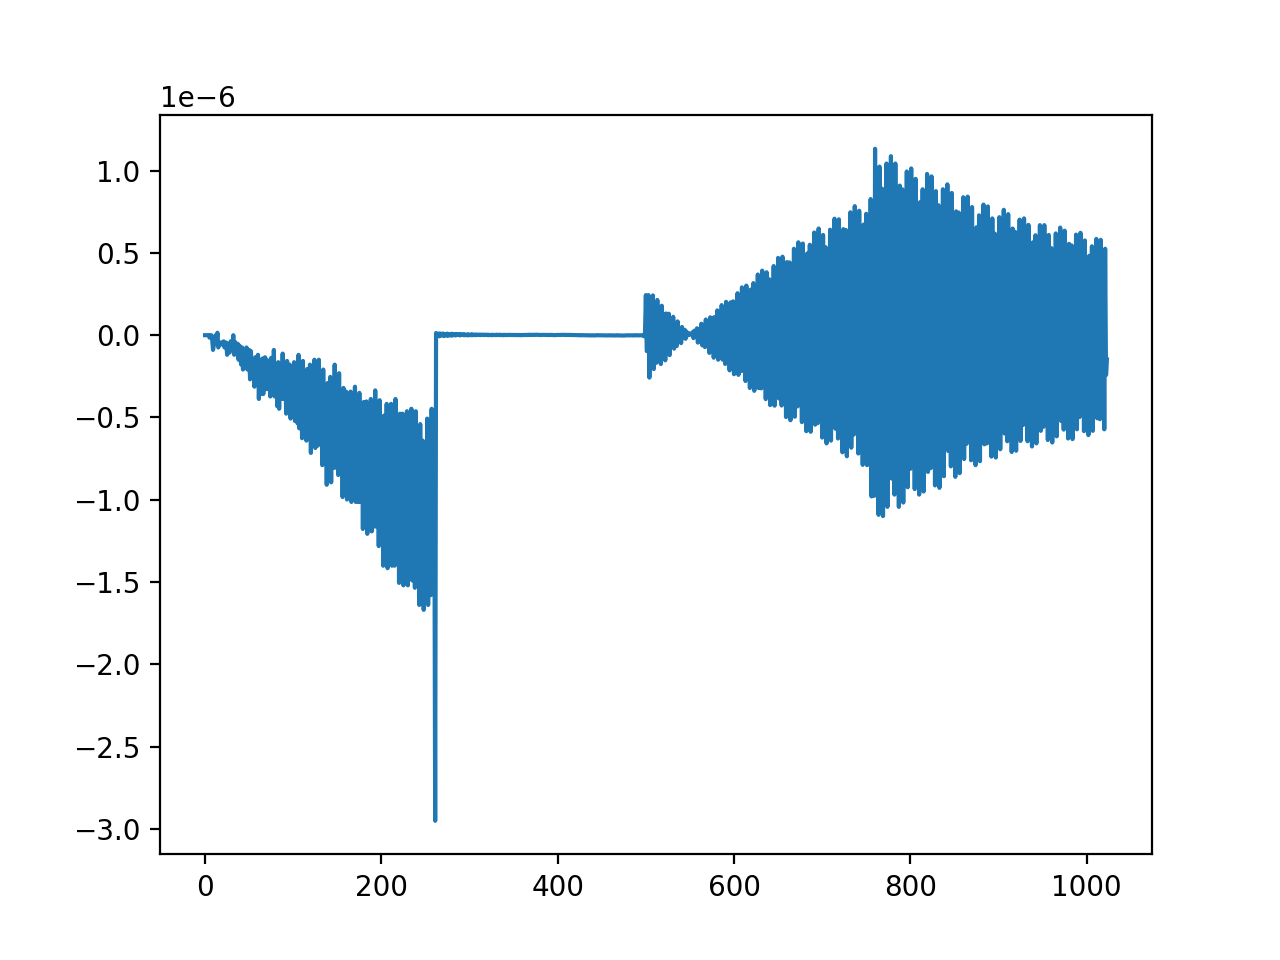

In [448]:
plt.figure()
plt.plot((saewoo-nader)[:1024])

<IPython.core.display.Javascript object>


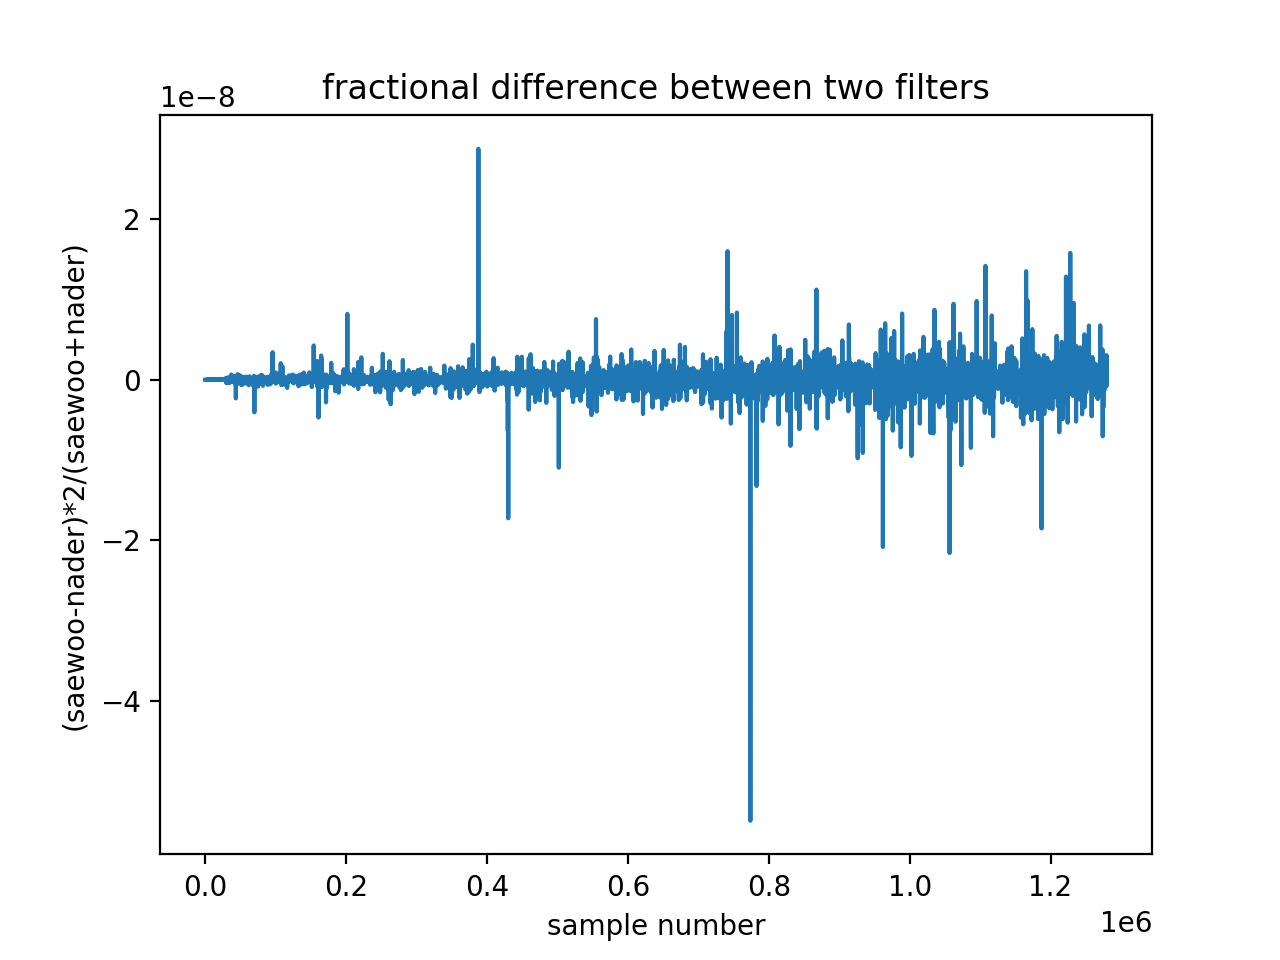

/var/folders/3t/7ztd8ysx38l1xvfndk0pq994000k7f/T/ipykernel_95556/237563025.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot((saewoo-nader)*2/(nader+saewoo))


Text(0.5, 1.0, 'fractional difference between two filters')

In [453]:
plt.figure()
plt.plot((saewoo-nader)*2/(nader+saewoo))
plt.ylabel('(saewoo-nader)*2/(saewoo+nader)')
plt.xlabel('sample number')
plt.title('fractional difference between two filters')

In [443]:
saewoo-filter_out

array([0., 0., 0., ..., 0., 0., 0.])

In [8]:
# Sliding Goertzel
@jit
def sg_v2(x, k=25*4):
    Pxx = []
    N = 64*4
    w = 2*np.pi*k/N;
    cw = np.cos(w);
    c = 2*cw;
    sw = np.sin(w);
    z1=0;
    z2=0;
    #while (idx < (len(x)-1)):
    for idx in range(len(x)):
        if idx<N:
            z0 = x[idx] + c*z1 - z2;
        else:
            z0 = x[idx] - x[idx-N] + c*z1 -z2;
        z2 = z1;
        z1 = z0;

        P = z2*z2 + z1*z1 - c * z1*z2
        Pxx.append(P)
    return np.array(Pxx)

In [9]:
raw = np.fromfile('single_tone_v2.dat', dtype=np.int32)
x = raw>>14

In [21]:
%timeit sg_v2(x[:256], k=100)
#sliding = sg(x, k=100)

The slowest run took 7.05 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 21.3 µs per loop


In [24]:
y = (2*sg_v2(x, k=100))**0.5

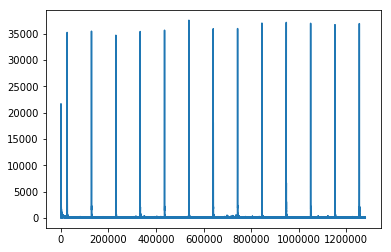

In [25]:
plt.plot(y)

In [28]:
(s2[255:] - sliding).sum()

0.0

In [36]:
raw = np.fromfile('/Users/nams/Downloads/RawData_initiatorOnly.dat', dtype=np.int32)
recording = raw>>14
y = (2*sg_v2(recording, k=100))**0.5

<IPython.core.display.Javascript object>


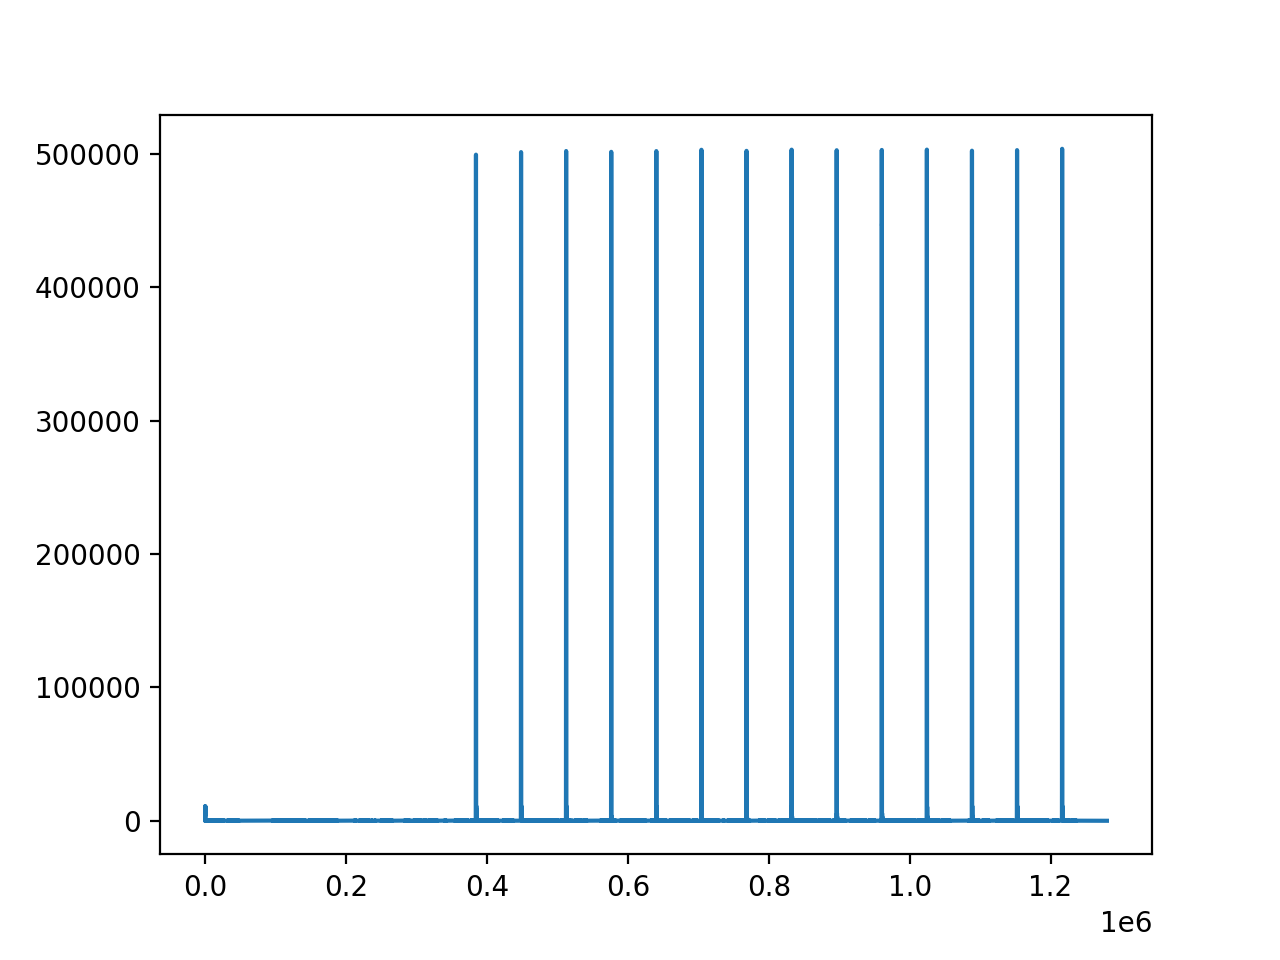

In [37]:
%matplotlib notebook
plt.figure()
plt.plot(y)

In [26]:
lag = 256
threshold = 5
influence = 1e-4
settings = (lag, threshold, influence)

filteredY = np.zeros(lag)
avgFilter = 0
std2 = 0
pk_info = [0, 0, 0]
time = -1
start = 0
write_addr = 0
found_one = False
length = 0

history = (filteredY, avgFilter, std2, pk_info, time, start, found_one, length, write_addr)
#@jit
def pk_find_block(y, settings, history):
    lag, threshold, influence = settings
    filteredY, avgFilter, std2, pk_info, time, start, found_one, length, write_addr = history

    peaks = []

    for i in range(len(y)):
        stdFilter = std2**0.5;
        time += 1
        oldValue = filteredY[(write_addr + i)%lag]
        if (y[i] - avgFilter) > threshold * stdFilter and (write_addr+i)>=lag:
            #print(i, 1, time)
            if not found_one:
                length = 1
                start = time
                found_one = True
            else:
                length += 1
            if y[i] > pk_info[1]:
                pk_info = [i, y[i], start, time]
            filteredY[(write_addr + i)%lag] = influence * y[i] + (1 - influence) * filteredY[((write_addr + i)-1)%lag]
        else:
            if found_one:
                if length>100:
                    pk_info.append(length)
                    peaks.append(pk_info)
                    # print("Mark Peak", 20*"*")
                    time = start + length - pk_info[3]
                    pk_info = [0, 0, 0]
                start = 0
                length = 0
                found_one = False
            filteredY[(write_addr + i)%lag] = y[i]
        prev_avg = avgFilter
        avgFilter = avgFilter + (filteredY[(write_addr + i)%lag] - oldValue) / lag
        std2 = std2 + (filteredY[(write_addr + i)%lag] - oldValue)*(filteredY[(write_addr + i)%lag] + oldValue - avgFilter - prev_avg) /lag
        #stdFilter = std2**0.5
    write_addr += len(y);
    #write_addr %= lag;
    # in the middle of a peak... record it anyway
#     if found_one:
#         if length>100 and (pk_info[0]+20) < i:
#             pk_info.append(length)
#             peaks.append(pk_info)
    history = (filteredY, avgFilter, std2, pk_info, time, start, found_one, length, write_addr)
    return peaks, history


15

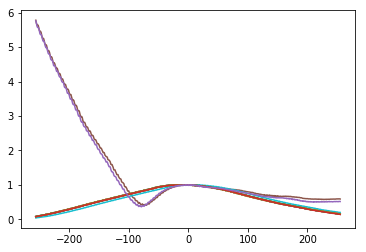

In [32]:
lag = 256
threshold = 5
influence = 1e-4
settings = (lag, threshold, influence)
filteredY = np.zeros(lag)
time=-1
start = 0
pk_find_block.write_addr = 0
pk_info = [0, 0, 0]
found_one = False
length = 0
write_addr = 0
history = (filteredY, avgFilter, std2, pk_info, time, start, found_one, length, write_addr)

peaks, history= pk_find_block(y, settings, history)
plt.figure()
count = 0
for pkinfo in peaks:
    idx = np.arange(pkinfo[0]-256, min(pkinfo[0]+256, len(y)))
    plt.plot(idx-pkinfo[0], y[idx]/pkinfo[1])
    count += 1
#peaks #, pk_find_block.write_addr, filteredY, avgFilter, std2
len(peaks)

In [31]:
peaks

[[26169, 35246.76273914424, 25874, 26169, 1250],
 [128569, 35489.29666356729, 102109, 102400, 588],
 [230969, 34712.375558673055, 102109, 102400, 589],
 [333369, 35423.24997654635, 102114, 102400, 579],
 [435768, 35674.1233978497, 102113, 102399, 579],
 [538170, 37568.66152397885, 102111, 102402, 593],
 [640570, 35950.980345918324, 102108, 102400, 1243],
 [742970, 35987.661551299294, 102109, 102400, 1237],
 [845351, 37026.29432413915, 102109, 102381, 584],
 [947769, 37154.85769558828, 102128, 102418, 584],
 [1050169, 36987.05679952423, 102109, 102400, 593],
 [1152569, 36731.42815123614, 102108, 102400, 589],
 [1254969, 36927.695199386675, 102114, 102400, 574]]

In [42]:
numba_test = np.fromfile('test_jit/sg2.out')

In [43]:
numba_test


array([   0.        ,    0.        ,    0.        , ..., 1460.22290834,
       3857.33151994, 2361.90384801])

In [44]:
y - (2*numba_test)**0.5

array([0., 0., 0., ..., 0., 0., 0.])

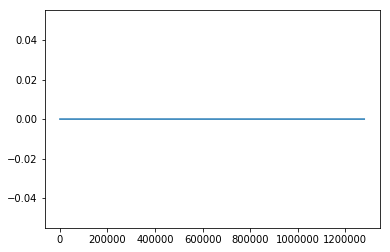

In [45]:
plt.plot(y- (2*numba_test)**0.5)